<a href="https://colab.research.google.com/github/yingzibu/ODE/blob/main/experiment/IV/one_compartment/multiple_dose_train_cycle_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## In reality, we only have Ac data

## And what if we have tlag? (Solved)

## What if multiple dosing?

In [1]:
! pip install torchdiffeq --quiet
! pip install latex --quiet

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


In [2]:
import os
import argparse
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint_adjoint as odeint
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import warnings

matplotlib.rcParams['figure.figsize'] = (3.5, 3)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [3]:
# constant
method_ode = 'dopri5'
data_size = 1000
batch_time = 10
batch_size = 64
niters = 2000
test_freq = 3
viz = True
gpu_num = 0
adjoint = True
fig_path = 'png'
device = torch.device('cuda:'+str(gpu_num) if torch.cuda.is_available() else 'cpu')

First order, thus ODE:
\begin{equation*}
     \frac{d A_c}{d t} =  - K A_c, \qquad  \text{IC} : A_c = D \text{ when } t = t_{\text{lag}};
\end{equation*}

solve this ODE and we obtain
\begin{align*}
    \frac{d A_c}{Ac} &= -K d t \\
    d \ln(A_c) &= d (-Kt) \\
    A_c &= {\rm C} {\rm e}^{-Kt}
\end{align*}
in which C is constant. Given the initial condition
Thus the equation is
\begin{equation*}
     A_c = D {\rm e}^{-K(t-t_{\rm lag})}
\end{equation*}
Usually $t_{\rm lag} = 0$, thus
\begin{align*}
    A_c &= D {\rm e}^{-Kt} \\
    Conc. & = \frac{D {\rm e}^{-Kt}}{V_d}
\end{align*}

If multiple dosing, the ODE remains the same, yet the condition changes at $t%\tau ==0$ as $A (\lambda * \tau) += MD$, in which $\lambda$ is the dosing repetition, $\tau$ is the dosing interval, and $MD$ is the maintenance dose (may or may not be the same as the loading dose)

### How to tackle multiple dosing? Like truncate into multiple intervals regarding to $\tau$?

In [15]:
# first order PO related constants
Dose = 24.0 # initial dose for PO, loading dose
MD = 8 # Maintenance dose
k = 0.2
MAX_T = 25
t_lag = 0.9
tau = 8 # dosing interval
lam = 4 # dosing lam times
apply_mask = False

MAX_T = max(MAX_T, tau*(lam+1))


In [17]:
true_M = torch.tensor([[-k]]).to(device)
true_y0 = torch.tensor([[Dose]]).to(device) # initial conditions for Aa and A
t = torch.linspace(t_lag, MAX_T+t_lag, data_size).to(device) # consider t_lag

dim = true_y0.shape[-1]
class Lambda(nn.Module):
    def forward(self, t, y, t_lag=t_lag): # need transpose M, since y is a row vector
        if t < t_lag: # consider lag time, return dy/dt = 0, thus Amount will remain the same
            return torch.mm(y, torch.zeros([dim,dim]).to(device))
        return torch.mm(y, true_M.T)

with torch.no_grad():
    for i in range(lam):
        t_here = t[t >= (t_lag + i * tau)]
        t_here = t_here[t_here < (t_lag + (i+1) * tau)]
        if i == 0:
            true_y = odeint(Lambda(),true_y0, t_here, method=method_ode)
        else:
            true_y = torch.cat([true_y, odeint(Lambda(),true_y0_here,
                                t_here, method=method_ode)], dim=0)
        A_res = true_y[-1]
        true_y0_here = torch.tensor([[MD + A_res]]).to(device) # A += MD
    t_here = t[t>=(t_lag + lam*tau)] # After the multiple dose, stop dosing
    true_y = torch.cat([true_y, odeint(Lambda(),true_y0_here,
                                       t_here, method=method_ode)], dim=0)

    assert true_y.shape[0] == t.shape[0]

In [18]:
class ODEFunc(nn.Module):
    """
    Aim: use NN to approximate ode_func.
    Input dim should be the same as output dim,
    since dy/dt has the same dim of y

    param dim: int, input dimension
    return
        dy/dt, which is ode_func value at y
    """
    def __init__(self, dim=dim, t_lag=t_lag):
        super(ODEFunc, self).__init__()
        self.t_lag = t_lag
        self.net = nn.Sequential(
            nn.Linear(dim, 50),
            nn.Tanh(),
            nn.Linear(50, dim)
        )
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)
    def forward(self, t, y):
        # if t < self.t_lag: # dy/dt = [0], no change in either compartment
            # return torch.zeros(y.shape)
        return self.net(y)




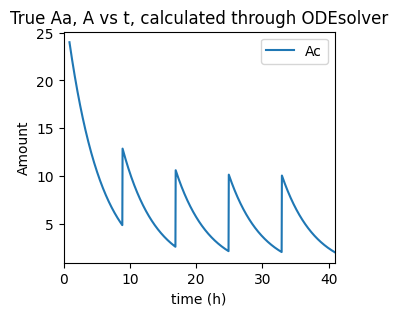

In [19]:
fig = plt.figure()
plt.plot(t.cpu().numpy(), true_y.cpu().numpy()[:,0,0])
t_max = t.max().cpu().numpy().item()
plt.legend(['Ac'])
plt.xlim([0., t_max])
plt.xlabel('time (h)')
plt.ylabel('Amount')
if apply_mask:
    plt.title('True Aa, A vs t, calculated through ODEsolver, Aa is ignored')
else:plt.title('True Aa, A vs t, calculated through ODEsolver')
plt.show()
plt.close()

## Explicit function

In [8]:
# def explicit_solution_IV_one_compartment(t, k=k, D=Dose, MD=MD,
#                                          t_lag=t_lag, lam=lam, tau=tau):

#     if t < t_lag:
#         A = np.array([[D]])
#     else:

#         t_here = t - t_lag
#         A = D * np.exp(-k * t_here)
#     return A.reshape(1,1)

# explicit_solution = explicit_solution_IV_one_compartment

# fig = plt.figure()
# true_y_explicit = np.stack(([explicit_solution(t_) for t_ in time_]))
# # print(true_y_explicit.shap?e)
# plt.plot(time_, true_y_explicit[:,0,0])
# t_max = t.max().cpu().numpy().item()


# plt.legend(['Ac'])
# plt.xlim([0., t_max])
# plt.xlabel('time (h)')
# plt.ylabel('Amount')
# plt.title('True Ac vs t, calculated through explicit solution')
# plt.show()
# plt.close()

In [20]:
selected_indices = t < (t_lag + tau)
selected_y = true_y[selected_indices].to(device)

print(selected_y.shape) # select only the first cycle of data

def get_batch(true_y=selected_y): # use the estimated ka to generate new batch data
    data_size = len(true_y)
    # print(data_size)
    # if batch_size > data_size: batch_size = int(data_size/5)
    s = torch.from_numpy(np.random.choice(np.arange(data_size-batch_time,
                                                    dtype=np.int64),
                         batch_size, replace=False))
    # print(s)
    batch_y0 = true_y[s]
    batch_t = t[:batch_time]
    batch_y = torch.stack([true_y[s+i] for i in range(batch_time)], dim=0)
    # try:
    #     if pred_ka != None and apply_mask == True:
    #         batch_y0[:, :, 0] = pred_y_pred_ka[s][:, :, 0]
    #         batch_y[:,:,:,0] = torch.stack([
    #             pred_y_pred_ka[s+i] for i in range(batch_time)], dim=0)[:,:,:,0]
    # except:
    #     pass


    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)

def makedirs(dirname):
    if not os.path.exists(dirname): os.makedirs(dirname)

torch.Size([200, 1, 1])


Epoch 0000 | Total Loss 42.880
Epoch 0003 | Total Loss 37.935
Epoch 0006 | Total Loss 33.061
Epoch 0009 | Total Loss 28.273
Epoch 0012 | Total Loss 23.584
Epoch 0015 | Total Loss 19.040
Epoch 0018 | Total Loss 14.760
Epoch 0021 | Total Loss 10.913
Epoch 0024 | Total Loss 7.667
Epoch 0027 | Total Loss 5.109
Epoch 0030 | Total Loss 3.193
Epoch 0033 | Total Loss 2.038
Epoch 0036 | Total Loss 1.677
Epoch 0039 | Total Loss 1.609
Epoch 0042 | Total Loss 1.652
Epoch 0045 | Total Loss 1.718
Epoch 0048 | Total Loss 1.795
Epoch 0051 | Total Loss 1.864
Epoch 0054 | Total Loss 1.895
Epoch 0057 | Total Loss 1.901
Epoch 0060 | Total Loss 1.883
Epoch 0063 | Total Loss 1.850
Epoch 0066 | Total Loss 1.793
Epoch 0069 | Total Loss 1.726
Epoch 0072 | Total Loss 1.647
Epoch 0075 | Total Loss 1.555
Epoch 0078 | Total Loss 1.460
Epoch 0081 | Total Loss 1.371
Epoch 0084 | Total Loss 1.283
Epoch 0087 | Total Loss 1.193
Epoch 0090 | Total Loss 1.108
Epoch 0093 | Total Loss 1.025
Epoch 0096 | Total Loss 0.949
Ep

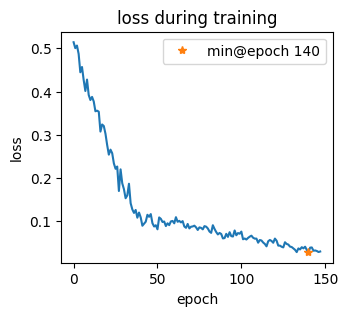

Epoch 0150 | Total Loss 0.280
Epoch 0153 | Total Loss 0.248
Epoch 0156 | Total Loss 0.190
Epoch 0159 | Total Loss 0.197
Epoch 0162 | Total Loss 0.259
Epoch 0165 | Total Loss 0.308
Epoch 0168 | Total Loss 0.281
Epoch 0171 | Total Loss 0.258
Epoch 0174 | Total Loss 0.283
Epoch 0177 | Total Loss 0.320
Epoch 0180 | Total Loss 0.319
Epoch 0183 | Total Loss 0.278
Epoch 0186 | Total Loss 0.259
Epoch 0189 | Total Loss 0.285
Epoch 0192 | Total Loss 0.327
Epoch 0195 | Total Loss 0.361
Epoch 0198 | Total Loss 0.340
Epoch 0201 | Total Loss 0.336
Epoch 0204 | Total Loss 0.315
Epoch 0207 | Total Loss 0.347
Epoch 0210 | Total Loss 0.388
Epoch 0213 | Total Loss 0.267
Epoch 0216 | Total Loss 0.247
Epoch 0219 | Total Loss 0.347
Epoch 0222 | Total Loss 0.401
Epoch 0225 | Total Loss 0.281
Epoch 0228 | Total Loss 0.279
Epoch 0231 | Total Loss 0.368
Epoch 0234 | Total Loss 0.333
Epoch 0237 | Total Loss 0.261
Epoch 0240 | Total Loss 0.283
Epoch 0243 | Total Loss 0.276
Epoch 0246 | Total Loss 0.347
Epoch 0249

In [21]:
def visualize_dim_2(true_y, pred_y, odefunc, itr, fig_path=None):
    if fig_path==None: fig_path = 'png'; makedirs(fig_path)
    fig, (ax_traj, ax_phase, ax_vecfield) = plt.subplots(1, 3, figsize=(12,4))

    ax_traj.cla()
    ax_traj.set_title('Trajectories')
    ax_traj.set_xlabel('t')
    ax_traj.set_ylabel('Aa, A')


    """will only check the first cycle of data"""
    # sel_ind = t < (t_lag + tau)
    # _y = true_y[selected_indices]

    ax_traj.plot(t.cpu().numpy(), true_y.cpu().numpy()[:,0,0],
                 t.cpu().numpy(), true_y.cpu().numpy()[:,0,1], 'g-')
    ax_traj.plot(t.cpu().numpy(), pred_y.cpu().numpy()[:,0,0], '--',
                 t.cpu().numpy(), pred_y.cpu().numpy()[:,0,1], 'b--')
    ax_traj.set_xlim(t.cpu().numpy()[:sel_ind].min(), t.cpu().numpy()[:sel_ind].max())
    ax_traj.set_ylim(-0.1, Dose * 1.1) # Since Aa and A cannot exceed [0, Dose]
    ax_traj.legend(['True Aa', 'True A', 'Pred Aa', 'Pred A'])

    ax_phase.cla()
    ax_phase.set_title('Phase Portrait')
    ax_phase.set_xlabel('Aa')
    ax_phase.set_ylabel('A')
    ax_phase.plot(true_y.cpu().numpy()[:, 0, 0], true_y.cpu().numpy()[:, 0, 1], 'g-')
    ax_phase.plot(pred_y.cpu().numpy()[:, 0, 0], pred_y.cpu().numpy()[:, 0, 1], 'b--')
    ax_phase.set_xlim(-0.1, Dose*1.1) # since Aa cannot exceed [0, Dose]
    ax_phase.set_ylim(-0.1, Dose*1.1) # since A  cannot exceed [0, Dose]
    ax_phase.legend(['True', 'Pred'])

    ax_vecfield.cla()
    ax_vecfield.set_title('Learned Vector Field')
    ax_vecfield.set_xlabel('Aa')
    ax_vecfield.set_ylabel('A')

    y, x = np.mgrid[-2:2:21j, -2:2:21j]
    dydt = odefunc(0, torch.Tensor(np.stack([x, y], -1).reshape(21 * 21, 2)).to(device)).cpu().detach().numpy()
    mag = np.sqrt(dydt[:, 0]**2 + dydt[:, 1]**2).reshape(-1, 1)
    dydt = (dydt / mag)
    dydt = dydt.reshape(21, 21, 2)

    ax_vecfield.streamplot(x, y, dydt[:, :, 0], dydt[:, :, 1], color="black")
    ax_vecfield.set_xlim(-2, 2)
    ax_vecfield.set_ylim(-2, 2)


    # plt.savefig('png/{:03d}'.format(itr))
    fig.suptitle('Iteration {:03d}'.format(itr))
    fig.tight_layout()
    fig.savefig('png/{:03d}'.format(itr))
    # plt.draw()
    # plt.pause(0.001)
    plt.close(fig)



def visualize_dim_1(true_y, pred_y, mean_df, itr, fig_path=None, true_k=k, cycle1=True):
    if fig_path==None: fig_path = 'png'; makedirs(fig_path)
    fig, (ax_traj, ax_k) = plt.subplots(1, 2, figsize=(8,4))

    ax_traj.cla()
    ax_traj.set_title('Trajectories')
    ax_traj.set_xlabel('t')
    ax_traj.set_ylabel('Ac')
    if cycle1==True: sel_ind = t < (t_lag + tau)
    else: sel_ind = t <= MAX_T
    time_ = t[sel_ind].cpu().numpy()

    ax_traj.plot(time_, true_y[sel_ind].cpu().numpy()[:,0,0])
    ax_traj.plot(time_, pred_y[sel_ind].cpu().numpy()[:,0,0], 'g--')

    t_max = t.max().cpu().numpy().item()

    ax_traj.set_xlim([0., t_max])
    ax_traj.set_ylim([-0.1, Dose*1.1])
    ax_traj.legend(['True A', 'Pred A'])

    ax_k.cla()
    ax_k.set_title('Model prediction of -k')
    ax_k.set_xlabel('iter')
    ax_k.set_ylabel('value')
    ax_k.plot(np.arange(ii+1), mean_df.iloc[0].tolist(), marker='.',
              label=f'pred -k = {mean_df.iloc[0].tolist()[-1]:.3f}')
    ax_k.axhline(y=-k, color='r', linestyle='-', label=f'true value={-k:.3f}')
    ax_k.legend(loc='upper right')
    # plt.title('True Aa, A vs t, calculated through explicit solution')

    # plt.savefig('png/{:03d}'.format(itr))
    fig.suptitle('Iteration {:03d}'.format(itr))
    fig.tight_layout()
    fig.savefig('png/{:03d}'.format(itr))

    plt.close(fig)



if dim == 1: visualize = visualize_dim_1
if dim == 2: visualize = visualize_dim_2
ii = 0
func = ODEFunc().to(device)
optimizer = optim.AdamW(func.parameters(), lr=1e-3, weight_decay=1e-4)
# end = time.time()
min_loss = np.inf
min_epoch = 0
loss_all = []
patience = 50
fig_freq = 50
model_path_ = 'test.pt'
mean_df = pd.DataFrame()

if apply_mask: pred_ka = 0 # initialize pred_ka

for epoch in range(niters):
    func.train()
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch()
    pred_y = odeint(func, batch_y0, batch_t).to(device)
    loss = torch.mean(torch.abs(pred_y-batch_y))
    loss_all.append(loss.item())
    loss.backward()
    optimizer.step()

    if loss.item() < min_loss: # loss drop, save model
        min_loss = loss.item(); min_epoch = epoch
        torch.save(func.state_dict(), model_path_)

    if epoch - min_epoch > patience:
        print('early stop'); break

    if epoch % test_freq == 0:
        func.eval()
        with torch.no_grad():

            for i in range(lam):
                t_here = t[t >= (t_lag + i * tau)]
                t_here = t_here[t_here < (t_lag + (i+1) * tau)]
                if i == 0:
                    pred_y = odeint(func,true_y0, t_here, method=method_ode)
                else:
                    pred_y = torch.cat([pred_y, odeint(func,true_y0_here,
                                        t_here, method=method_ode)], dim=0)
                A_res = pred_y[-1]
                true_y0_here = torch.tensor([[MD + A_res]]).to(device) # A += MD

            t_here = t[t>=(t_lag + lam*tau)] # After the multiple dose, stop dosing
            pred_y = torch.cat([pred_y, odeint(func,true_y0_here,
                                            t_here, method=method_ode)], dim=0)

            assert pred_y.shape[0] == t.shape[0]


            loss = torch.mean(torch.abs(pred_y-true_y)) # all loss, include Aa
            print('Epoch {:04d} | Total Loss {:.3f}'.format(epoch, loss.item()))


            y_nn = func(_, true_y)
            y_nn = y_nn.reshape(y_nn.shape[0], dim).cpu().detach()
            y_temp = true_y.reshape(true_y.shape[0], dim).cpu().detach()
            M_T = torch.linalg.inv(y_temp.T @ y_temp)
            M_T = M_T @ y_temp.T @ y_nn
            M_T = M_T.reshape(dim*dim).numpy()
            # print(M_T, type(M_T))
            if apply_mask: # update pred_ka
                pred_ka = M_T[1]
                if pred_ka < 0: pred_ka = 0
                print('update pred_ka:', pred_ka)

            mean_df[f'iter {ii}'] = pd.DataFrame(M_T)



            if viz: visualize(true_y, pred_y, mean_df, ii,cycle1=False) # ii is the png figure pass num

            # fig, axs = plt.subplots(dim, dim, figsize=(10,5))
            # true_values = true_M.T.cpu().detach().numpy().reshape(dim*dim)

            # for i in range(dim):
            #     for j in range(dim):
            #         axs[i][j].cla(); idx = j*dim + i
            #         true_value = true_values[idx]
            #         axs[i][j].plot(
            #             np.arange(ii+1), mean_df.iloc[idx].tolist(), marker='.',
            #             label=f'pred M{i,j} = {mean_df.iloc[idx].tolist()[-1]:.3f}')
            #         axs[i][j].axhline(y=true_value, color='r', linestyle='-',
            #                           label=f'true value = {true_value:.3f}')
            #         axs[i][j].legend(loc='upper right')
            # fig.suptitle('Model estimation of M during train, iter={:03d}'.format(ii))
            # fig.tight_layout()
            # makedirs('M_estimate')
            # fig.savefig('M_estimate/{:03d}'.format(ii))


            ii += 1

            # if ii % fig_freq == 0: plt.show(fig)
            # plt.close(fig)


            # Visualize loss during training
            if ii % fig_freq == 0:
                plt.plot(loss_all)
                plt.plot(min_epoch, min_loss, '*',
                         label=f'min@epoch {min_epoch}')
                plt.xlabel('epoch'); plt.ylabel('loss');
                plt.title('loss during training')
                plt.legend(); plt.show(); plt.close()


load model from path:  test.pt


<ipython-input-22-6547e217b81b>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_location=device))


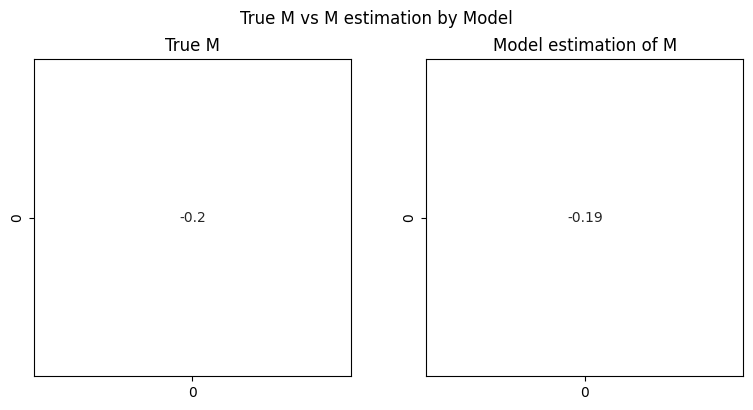

In [22]:
def load_model(model, path, device='cpu'):
    print('load model from path: ', path)
    model.load_state_dict(torch.load(path, map_location=device))

load_model(func, model_path_)

y_nn = func(_, true_y)
y_temp = true_y.reshape(true_y.shape[0], dim).cpu().detach()
M_T = torch.linalg.inv(y_temp.T @ y_temp)
M_T = M_T @ y_temp.T @ (y_nn.reshape(y_nn.shape[0], dim).cpu().detach())

true_M_ = true_M.cpu().detach().numpy()
pred_M_ = M_T.T.numpy()
fig, (ax_true, ax_pred) = plt.subplots(1, 2, figsize=(8,4))

ax_true.cla()

sns.heatmap(true_M_, annot=True, square=True,
            cmap='gray_r', vmin=0, vmax=0,  # set all to white
            linewidths=0.5, linecolor='k',  # draw black grid lines
            cbar=False, ax=ax_true)         # disable colorbar
sns.despine(left=False, right=False, top=False, bottom=False)
ax_true.set_title('True M')

ax_pred.cla()
sns.heatmap(pred_M_, annot=True, square=True,
            cmap='gray_r', vmin=0, vmax=0,  # set all to white
            linewidths=0.5, linecolor='k',  # draw black grid lines
            cbar=False, ax=ax_pred)         # disable colorbar
sns.despine(left=False, right=False, top=False, bottom=False)
ax_pred.set_title('Model estimation of M')

fig.suptitle('True M vs M estimation by Model')
fig.tight_layout(); plt.show(fig); plt.close(fig)

<ipython-input-23-4f1c972f006e>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


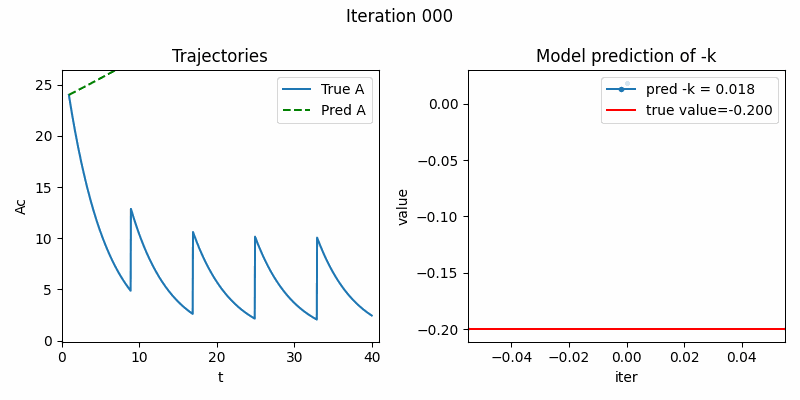

In [23]:
import imageio
images = []
# for filename in filenames:
for i in range(ii):
    filename = '{:03d}.png'.format(i)
    filename = f'{fig_path}/{filename}'
    images.append(imageio.imread(filename))
imageio.mimsave('png/gif.gif', images, fps=3)
from IPython.display import Image
Image('png/gif.gif')

In [24]:
with torch.no_grad():
    for i in range(lam):
        t_here = t[t >= (t_lag + i * tau)]
        t_here = t_here[t_here < (t_lag + (i+1) * tau)]
        if i == 0:
            pred_y = odeint(func,true_y0, t_here, method=method_ode)
        else:
            pred_y = torch.cat([pred_y, odeint(func,true_y0_here,
                                t_here, method=method_ode)], dim=0)
        A_res = pred_y[-1]
        true_y0_here = torch.tensor([[MD + A_res]]).to(device) # A += MD

    t_here = t[t>=(t_lag + lam*tau)] # After the multiple dose, stop dosing
    pred_y = torch.cat([pred_y, odeint(func,true_y0_here,
                                       t_here, method=method_ode)], dim=0)

    assert pred_y.shape[0] == t.shape[0]

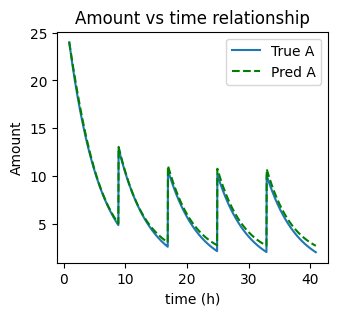

In [25]:
fig = plt.figure()

plt.plot(t.cpu().numpy(), true_y.cpu().numpy()[:,0,0])
plt.plot(t.cpu().numpy(), pred_y.cpu().numpy()[:,0,0], 'g--')
plt.legend(['True A', 'Pred A'])
plt.xlabel('time (h)')
plt.ylabel('Amount')
plt.title('Amount vs time relationship')
plt.show(); plt.close()